In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import pandas

In [7]:
from functools import partial
import torch
import os
import PIL
from torchvision.datasets import VisionDataset
from torchvision.datasets.utils import download_file_from_google_drive, check_integrity, verify_str_arg


class CelebA(VisionDataset):
    """`Large-scale CelebFaces Attributes (CelebA) Dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        split (string): One of {'train', 'valid', 'test', 'all'}.
            Accordingly dataset is selected.
        target_type (string or list, optional): Type of target to use, ``attr``, ``identity``, ``bbox``,
            or ``landmarks``. Can also be a list to output a tuple with all specified target types.
            The targets represent:
                ``attr`` (np.array shape=(40,) dtype=int): binary (0, 1) labels for attributes
                ``identity`` (int): label for each person (data points with the same identity are the same person)
                ``bbox`` (np.array shape=(4,) dtype=int): bounding box (x, y, width, height)
                ``landmarks`` (np.array shape=(10,) dtype=int): landmark points (lefteye_x, lefteye_y, righteye_x,
                    righteye_y, nose_x, nose_y, leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y)
            Defaults to ``attr``. If empty, ``None`` will be returned as target.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """

    base_folder = "celeba"
    # There currently does not appear to be a easy way to extract 7z in python (without introducing additional
    # dependencies). The "in-the-wild" (not aligned+cropped) images are only in 7z, so they are not available
    # right now.
    file_list = [
        # File ID                         MD5 Hash                            Filename
        ("0B7EVK8r0v71pTUZsaXdaSnZBZzg", "00d2c5bc6d35e252742224ab0c1e8fcb", "img_align_celeba.zip"),
        # ("0B7EVK8r0v71pbWNEUjJKdDQ3dGc", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_align_celeba_png.7z"),
        # ("0B7EVK8r0v71peklHb0pGdDl6R28", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_celeba.7z"),
        ("0B7EVK8r0v71pblRyaVFSWGxPY0U", "75e246fa4810816ffd6ee81facbd244c", "list_attr_celeba.txt"),
        ("1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS", "32bd1bd63d3c78cd57e08160ec5ed1e2", "identity_CelebA.txt"),
        ("0B7EVK8r0v71pbThiMVRxWXZ4dU0", "00566efa6fedff7a56946cd1c10f1c16", "list_bbox_celeba.txt"),
        ("0B7EVK8r0v71pd0FJY3Blby1HUTQ", "cc24ecafdb5b50baae59b03474781f8c", "list_landmarks_align_celeba.txt"),
        # ("0B7EVK8r0v71pTzJIdlJWdHczRlU", "063ee6ddb681f96bc9ca28c6febb9d1a", "list_landmarks_celeba.txt"),
        ("0B7EVK8r0v71pY0NSMzRuSXJEVkk", "d32c9cbf5e040fd4025c592c306e6668", "list_eval_partition.txt"),
    ]

    def __init__(self, root, split="train", target_type="attr", transform=None,
                 target_transform=None, download=False):
        import pandas
        super(CelebA, self).__init__(root, transform=transform,
                                     target_transform=target_transform)
        self.split = split
        if isinstance(target_type, list):
            self.target_type = target_type
        else:
            self.target_type = [target_type]

        if not self.target_type and self.target_transform is not None:
            raise RuntimeError('target_transform is specified but target_type is empty')

        if download:
            self.download()

#         print(f"{self._check_integrity()=}")
#         if not self._check_integrity():
#             raise RuntimeError('Dataset not found or corrupted.' +
#                                ' You can use download=True to download it')

        split_map = {
            "train": 0,
            "valid": 1,
            "test": 2,
            "all": None,
        }
        split = split_map[verify_str_arg(split.lower(), "split",
                                         ("train", "valid", "test", "all"))]

        fn = partial(os.path.join, self.root, self.base_folder)
        splits = pandas.read_csv(fn("list_eval_partition.txt"), delim_whitespace=True, header=None, index_col=0)
        identity = pandas.read_csv(fn("identity_CelebA.txt"), delim_whitespace=True, header=None, index_col=0)
        bbox = pandas.read_csv(fn("list_bbox_celeba.txt"), delim_whitespace=True, header=1, index_col=0)
        landmarks_align = pandas.read_csv(fn("list_landmarks_align_celeba.txt"), delim_whitespace=True, header=1)
        attr = pandas.read_csv(fn("list_attr_celeba.txt"), delim_whitespace=True, header=1)

        mask = slice(None) if split is None else (splits[1] == split)

        self.filename = splits[mask].index.values
        self.identity = torch.as_tensor(identity[mask].values)
        self.bbox = torch.as_tensor(bbox[mask].values)
        self.landmarks_align = torch.as_tensor(landmarks_align[mask].values)
        self.attr = torch.as_tensor(attr[mask].values)
        self.attr = (self.attr + 1) // 2  # map from {-1, 1} to {0, 1}
        self.attr_names = list(attr.columns)

    def _check_integrity(self):
        for (_, md5, filename) in self.file_list:
            print(f"{filename=}\t{md5=}")
            fpath = os.path.join(self.root, self.base_folder, filename)
            _, ext = os.path.splitext(filename)
            # Allow original archive to be deleted (zip and 7z)
            # Only need the extracted images
            print(check_integrity(fpath, md5))
            if ext not in [".zip", ".7z"] and not check_integrity(fpath, md5):
                return False
        # Should check a hash of the images
        return os.path.isdir(os.path.join(self.root, self.base_folder, "img_align_celeba"))

    def download(self):
        import zipfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        for (file_id, md5, filename) in self.file_list:
            download_file_from_google_drive(file_id, os.path.join(self.root, self.base_folder), filename, md5)

        with zipfile.ZipFile(os.path.join(self.root, self.base_folder, "img_align_celeba.zip"), "r") as f:
            f.extractall(os.path.join(self.root, self.base_folder))

    def __getitem__(self, index):
        X = PIL.Image.open(os.path.join(self.root, self.base_folder, "img_align_celeba", self.filename[index]))

        target = []
        for t in self.target_type:
            if t == "attr":
                target.append(self.attr[index, :])
            elif t == "identity":
                target.append(self.identity[index, 0])
            elif t == "bbox":
                target.append(self.bbox[index, :])
            elif t == "landmarks":
                target.append(self.landmarks_align[index, :])
            else:
                # TODO: refactor with utils.verify_str_arg
                raise ValueError("Target type \"{}\" is not recognized.".format(t))

        if self.transform is not None:
            X = self.transform(X)

        if target:
            target = tuple(target) if len(target) > 1 else target[0]

            if self.target_transform is not None:
                target = self.target_transform(target)
        else:
            target = None

        return X, target

    def __len__(self):
        return len(self.attr)

    def extra_repr(self):
        lines = ["Target type: {target_type}", "Split: {split}"]
        return '\n'.join(lines).format(**self.__dict__)

In [8]:
transform =transforms.Compose([transforms.ToTensor()]) #didn't add transforms.Normalize

In [9]:
batch_size = 8

In [12]:
trainset = CelebA('./',split='train', target_type='identity',download=False, transform=transform, target_transform = None)

/var/folders/45/f7c2jlxs4296lyr5sxsr5wfc0000gn/T/ipykernel_15331/616275015.py:96: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.attr = (self.attr + 1) // 2  # map from {-1, 1} to {0, 1}


In [13]:
trainset[0]

(tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.9686, 0.9961, 0.9961],
          [0.9922, 0.9922, 0.9922,  ..., 0.9765, 0.9961, 0.9961],
          [0.9922, 0.9922, 0.9922,  ..., 0.9804, 1.0000, 1.0000],
          ...,
          [0.5490, 0.4549, 0.5725,  ..., 0.4784, 0.4784, 0.4784],
          [0.5098, 0.5412, 0.6510,  ..., 0.4627, 0.4627, 0.4627],
          [0.6588, 0.8000, 0.9608,  ..., 0.4627, 0.4706, 0.4706]],
 
         [[0.9059, 0.9059, 0.9059,  ..., 0.8863, 0.9333, 0.9333],
          [0.9059, 0.9059, 0.9059,  ..., 0.8941, 0.9333, 0.9333],
          [0.9059, 0.9059, 0.9059,  ..., 0.9059, 0.9373, 0.9373],
          ...,
          [0.2902, 0.1882, 0.3059,  ..., 0.2157, 0.2196, 0.2196],
          [0.2431, 0.2745, 0.3843,  ..., 0.1922, 0.2000, 0.2000],
          [0.3922, 0.5333, 0.6941,  ..., 0.1922, 0.1961, 0.1961]],
 
         [[0.7608, 0.7608, 0.7608,  ..., 0.8824, 0.8706, 0.8706],
          [0.7608, 0.7608, 0.7608,  ..., 0.8824, 0.8706, 0.8706],
          [0.7608, 0.7608, 0.7608,  ...,

In [14]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,num_workers=0)

In [15]:
#testset = torchvision.datasets.CelebA('./',train=False,download=True, transform=transform)

In [16]:
testset = CelebA('./',split='test', target_type='identity',download=False, transform=transform, target_transform = None)

/var/folders/45/f7c2jlxs4296lyr5sxsr5wfc0000gn/T/ipykernel_15331/616275015.py:96: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.attr = (self.attr + 1) // 2  # map from {-1, 1} to {0, 1}


In [19]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True,num_workers=0)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*4*4,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
#define the network

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#define loss function and optimizer

#normally use cross-entropyloss for classification problem
#nn.MSELoss for regression problem


In [11]:
#for name, i in net.named_parameters():
    #print(f"{name}")
    
#list out the parameters that can be trained

In [50]:
labels

tensor([9, 1, 2, 4, 7, 0, 6, 7])

In [12]:
for epoch in range(2):
    Loss = 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
#inputs is the image
#outputs is the labels 

#Train the network in the training data

In [13]:
PATH = './Mnist_net.pt'
torch.save(net.state_dict(), PATH)
#save the trained model as PATH

#for future use, open empty jupyter
#1.define the network
#2.net = Net()
#net.load_state_dict(torch.load(PATH)) 

In [33]:
import matplotlib.pyplot as plt
dataiter = iter(testloader)
inputs, labels = dataiter.next()
print(f'{(inputs.shape)}')

#iterate testloader

torch.Size([8, 1, 28, 28])


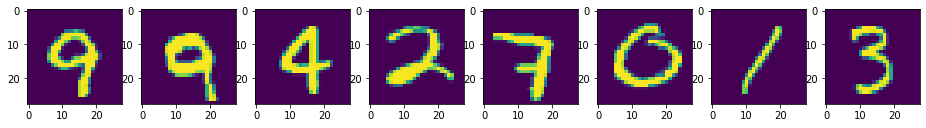

In [34]:
fig, axes = plt.subplots(1,8, figsize=(16,4))
for x, ax in zip(inputs, axes):
    ax.imshow(x.squeeze(0))
    
#plot out the first 8 inputs

In [35]:
net = Net()
net.load_state_dict(torch.load(PATH))

#load back saved model


<All keys matched successfully>

In [36]:
outputs = net(inputs)
#subs testing inputs into saved model

In [37]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

#test the network on the test data

Predicted:      9     9     4     2     7     0     1     3


In [48]:
correct = 0
total = 0
#initialize number of testset

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        #max function will give 2 outcome
        #x_random = torch.randn(8,10)
        #torch.max(x_random,1) 
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %d %%' % (100 * correct / total))

#calculate the accuracy of the network on the testset

Accuracy: 98 %
